In [112]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
from numpy.polynomial.polynomial import polyfit, polyval

In [114]:
cotton_price = 0.4
nitrogen_cost = 1.0
nitrogen_ratio = nitrogen_cost/cotton_price
sq_rate = 100.0
sq_yield = 4500.0
rst_b2g = -0.02

In [115]:
trial = np.load('../data/Trial_Design.npy')
trial_names = np.load('../data/Trial_Design_names.npy', allow_pickle=True)
trial_coords = np.load('../data/Trial_Design_coords.npy')
trial_coords_idx = np.int0(np.floor(trial_coords/3))
n = trial_coords.shape[0]

rst_sim = np.load('../data/Trial_sim.npy')

In [116]:
b0_true = rst_sim[:100]
b1_true = rst_sim[100:]

opt_pct = 150
rst_optr = opt_pct/100 * 100 * (1 + 0.25 * b1_true) 
rst_optr = np.clip(rst_optr, 0, 200)

rst_b1 = -2 * rst_b2g * rst_optr + nitrogen_ratio
rst_b0 = sq_yield * (1 + 0.05 * b0_true)
rst_b0 = rst_b0 - (rst_b1 * rst_optr + rst_b2g * rst_optr **2) 

trial_idx = [i for i, n in enumerate(trial_names) if not 'rep' in n]# and 'p100' in n]

rst_yield_ref =  rst_b0 + rst_b1 * sq_rate + rst_b2g * sq_rate**2
rst_yield_opt_f =  rst_b0 + rst_b1 * opt_pct + rst_b2g * opt_pct**2
rst_yield_opt =  rst_b0 + rst_b1 * rst_optr + rst_b2g * rst_optr**2

rst_net_ref = rst_yield_ref * cotton_price - sq_rate * nitrogen_cost
rst_net_opt_f = rst_yield_opt_f * cotton_price - opt_pct * nitrogen_cost 
rst_net_opt = rst_yield_opt * cotton_price - rst_optr * nitrogen_cost 

rst_net_f = (rst_net_opt_f - rst_net_ref).mean((1,2))
rst_net_max = (rst_net_opt - rst_net_ref).mean((1,2))

rst_net_f.mean(), rst_net_max.mean()

(18.77470387841445, 28.43628837027071)

In [117]:
resultsdf = []
idx = 2
# if True:
for idx in tqdm(trial_idx):
    exp_name = trial_names[idx]
    print(exp_name)
    #Converting to float is very important!
    rst_optr_pred = np.load(f'../data/{exp_name}_{opt_pct}.npy').astype('float32')
    rst_optr_predc = [polyval(x.flatten(), polyfit(x.flatten(), y.flatten(), deg = 1)) for x, y in zip(rst_optr_pred, rst_optr)]
    rst_optr_pred = np.stack(rst_optr_predc).reshape(rst_optr_pred.shape)

#     avg_nrate = opt_pct - rst_optr_pred.mean((1,2))[:,None,None]
#     rst_optr_pred = rst_optr_pred + avg_nrate

    trial_rst = np.nan_to_num(trial[idx])
    inp_rate = sq_rate + 12.5 * trial_rst
    
    rst_yield_obs =  rst_b0 + rst_b1 * inp_rate + rst_b2g * inp_rate**2
    rst_yield_pred =  rst_b0 + rst_b1 * rst_optr_pred + rst_b2g * rst_optr_pred**2

    rst_net_obs = rst_yield_obs * cotton_price - inp_rate * nitrogen_cost 
    rst_net_pred = rst_yield_pred * cotton_price - rst_optr_pred * nitrogen_cost 

    rst_net_loss = (rst_net_obs - rst_net_ref).mean((1,2))
    rst_net_diff = (rst_net_pred - rst_net_ref).mean((1,2))
    rst_net_pct = 100 * rst_net_diff / rst_net_max.mean()
    avg_nrate = rst_optr_pred.mean((1,2))
    
    rnp = np.stack([rst_net_max, avg_nrate, rst_net_loss, rst_net_diff, rst_net_pct], -1)
    df = pd.DataFrame(rnp, columns=['Max', 'AVG', 'Loss', 'VRT', 'VRTpct'])
    df['Trial'] = exp_name
    df['Rep'] = np.arange(len(df))
    resultsdf.append(df)
    
resultsdf = pd.concat(resultsdf).reset_index(drop=True)
resultsdf.to_csv('../data/trial_eco.csv', index = False)

size03_p001
size03_p005
size03_p010
size03_p050
size03_p100
size06_p001
size06_p005
size06_p010
size06_p050
size06_p100
size15_p001
size15_p005
size15_p010
size15_p050
size15_p100
size30_p001
size30_p005
size30_p010
size30_p050
size30_p100
size60_p001
size60_p005
size60_p010
size60_p050
size60_p100
size01_p001
size01_p005
size01_p010
size01_p050
size01_p100



In [118]:
bad_idx = df.VRT.argmin()

In [119]:
rst_optr_pred[bad_idx]

array([[ 86.92736535, 108.17527622, 104.47998738, ..., 154.36638682,
        158.98549788, 123.88025383],
       [109.09909844, 138.66140921, 134.04229816, ..., 193.16691971,
        193.16691971, 159.90932009],
       [103.55616517, 131.27083152, 126.65172046, ..., 193.16691971,
        193.16691971, 153.4425646 ],
       ...,
       [110.02292065, 140.50905364, 136.81376479, ..., 170.07136442,
        176.5381199 , 134.96612037],
       [113.7182095 , 145.1281647 , 141.43287585, ..., 174.69047548,
        181.15723096, 138.66140921],
       [ 90.6226542 , 113.7182095 , 110.94674286, ..., 134.96612037,
        139.58523143, 109.09909844]])

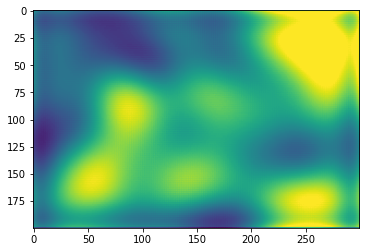

In [120]:
plt.imshow(rst_optr_pred[bad_idx])

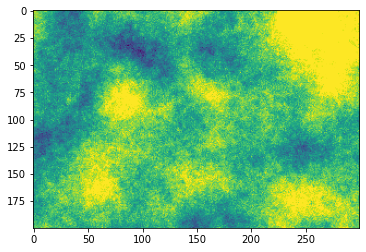

In [121]:
plt.imshow(rst_optr[bad_idx])